# Librerías

In [63]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from notebooks.time_series.arima.arima import (
    naive_model,
)

from sklearn.metrics import root_mean_squared_error

# skforecast
from skforecast.Sarimax import Sarimax

# statsmodels
from statsmodels.tsa.statespace.sarimax import SARIMAX

# pmdarima
from pmdarima import ARIMA
from pmdarima import auto_arima

## Leemos la data

In [64]:
train_df = pd.read_parquet("../../data/time_series/train_df.parquet").asfreq("D")
validation_df = pd.read_parquet("../../data/time_series/validation_df.parquet").asfreq(
    "D"
)
test_df = pd.read_parquet("../../data/time_series/test_df.parquet").asfreq("D")

# Arima optimo

In [97]:
model_pmd_arima = auto_arima(
    train_df["gap"],
    max_p=10,
    m=7,
    maxiter=500,
    seasonal=True,
    trace=True,
    error_action="ignore",
    suppress_warnings=True,
    stepwise=False,
)

# Resumen del modelo
print(model_pmd_arima.summary())

 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=99001.289, Time=0.06 sec
 ARIMA(0,1,0)(0,0,1)[7] intercept   : AIC=98903.473, Time=0.25 sec
 ARIMA(0,1,0)(0,0,2)[7] intercept   : AIC=98866.240, Time=0.75 sec
 ARIMA(0,1,0)(1,0,0)[7] intercept   : AIC=98885.407, Time=0.16 sec
 ARIMA(0,1,0)(1,0,1)[7] intercept   : AIC=inf, Time=2.50 sec
 ARIMA(0,1,0)(1,0,2)[7] intercept   : AIC=inf, Time=7.37 sec
 ARIMA(0,1,0)(2,0,0)[7] intercept   : AIC=98847.455, Time=0.59 sec
 ARIMA(0,1,0)(2,0,1)[7] intercept   : AIC=inf, Time=7.11 sec
 ARIMA(0,1,0)(2,0,2)[7] intercept   : AIC=inf, Time=18.09 sec
 ARIMA(0,1,1)(0,0,0)[7] intercept   : AIC=97645.023, Time=0.21 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=97410.740, Time=0.54 sec
 ARIMA(0,1,1)(0,0,2)[7] intercept   : AIC=97359.585, Time=1.60 sec
 ARIMA(0,1,1)(1,0,0)[7] intercept   : AIC=97361.606, Time=0.50 sec
 ARIMA(0,1,1)(1,0,1)[7] intercept   : AIC=inf, Time=4.18 sec
 ARIMA(0,1,1)(1,0,2)[7] intercept   : AIC=inf, Time=15.88 sec
 ARIMA(0,1,1)(2,0,0)[7] inter

# Model Building

## Naive model

In [86]:
rmse_naive, mape_naive = naive_model(
    train_df=train_df, test_df=validation_df, column_name="gap"
)

Naive approach:
RMSE: 16268.436428659435
MAPE: 17.11%


## Arima statsmodels

In [98]:
model = SARIMAX(
    endog=train_df["gap"], order=(1, 1, 3), seasonal_order=(1, 0, 0, 7), freq="D"
)
model_res = model.fit(disp=0)
model_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                gap   No. Observations:                 4992
Model:             SARIMAX(1, 1, 3)x(1, 0, [], 7)   Log Likelihood              -48563.258
Date:                            Sat, 25 May 2024   AIC                          97138.517
Time:                                    14:31:25   BIC                          97177.609
Sample:                                11-01-2001   HQIC                         97152.219
                                     - 07-02-2015                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4870      0.098      4.993      0.000       0.296       0.678
ma.L1         -1.1112      0.097    -11.492      0.000      -1.301      -0.922
ma.L2          0.0945      0.062      1.519      0.129      -0.027       0.216
ma.L3          0.1289      0.016      7.891      0.000       0.097       0.161
ar.S.L7        0.2108      0.006     36.423      0.000       0.199       0.222
sigma2      1.703e+07   2.46e-08   6.94e+14      0.000     1.7e+07     1.7e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.14   Jarque-Bera (JB):            326121.74
Prob(Q):                              0.71   Prob(JB):                         0.00
Heteroskedasticity (H):             725.80   Skew:                             2.58
Prob(H) (two-sided):                  0.00   Kurtosis:                        42.26
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.8e+29. Standard errors may be unstable.
"""

In [99]:
predictions_statsmodels = model_res.get_forecast(
    steps=len(validation_df["gap"])
).predicted_mean
predictions_statsmodels.name = "predictions_statsmodels"

## Arima Skforecaster

In [100]:
model = Sarimax(order=(1, 1, 3), seasonal_order=(1, 0, 0, 7))
model.fit(y=train_df["gap"])
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                gap   No. Observations:                 4992
Model:             SARIMAX(1, 1, 3)x(1, 0, [], 7)   Log Likelihood              -48563.258
Date:                            Sat, 25 May 2024   AIC                          97138.517
Time:                                    14:31:27   BIC                          97177.609
Sample:                                11-01-2001   HQIC                         97152.219
                                     - 07-02-2015                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4870      0.098      4.993      0.000       0.296       0.678
ma.L1         -1.1112      0.097    -11.492      0.000      -1.301      -0.922
ma.L2          0.0945      0.062      1.519      0.129      -0.027       0.216
ma.L3          0.1289      0.016      7.891      0.000       0.097       0.161
ar.S.L7        0.2108      0.006     36.423      0.000       0.199       0.222
sigma2      1.703e+07   2.46e-08   6.94e+14      0.000     1.7e+07     1.7e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.14   Jarque-Bera (JB):            326121.74
Prob(Q):                              0.71   Prob(JB):                         0.00
Heteroskedasticity (H):             725.80   Skew:                             2.58
Prob(H) (two-sided):                  0.00   Kurtosis:                        42.26
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.8e+29. Standard errors may be unstable.
"""

In [101]:
predictions_skforecast = model.predict(steps=len(validation_df["gap"]))
predictions_skforecast.columns = ["skforecast"]

## pdmarima

In [102]:
model_pmd_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                 4992
Model:             SARIMAX(1, 1, 3)x(1, 0, [], 7)   Log Likelihood              -48545.202
Date:                            Sat, 25 May 2024   AIC                          97104.403
Time:                                    14:31:28   BIC                          97150.011
Sample:                                11-01-2001   HQIC                         97120.390
                                     - 07-02-2015                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     53.5535     21.638      2.475      0.013      11.143      95.964
ar.L1         -0.9082      0.012    -77.369      0.000      -0.931      -0.885
ma.L1          0.3128      0.013     24.341      0.000       0.288       0.338
ma.L2         -0.7272      0.009    -84.123      0.000      -0.744      -0.710
ma.L3         -0.2293      0.006    -37.239      0.000      -0.241      -0.217
ar.S.L7        0.2432      0.006     42.144      0.000       0.232       0.254
sigma2      1.703e+07      0.002   6.86e+09      0.000     1.7e+07     1.7e+07
===================================================================================
Ljung-Box (L1) (Q):                   1.35   Jarque-Bera (JB):            351025.79
Prob(Q):                              0.25   Prob(JB):                         0.00
Heteroskedasticity (H):             552.83   Skew:                             2.76
Prob(H) (two-sided):                  0.00   Kurtosis:                        43.71
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 9.96e+23. Standard errors may be unstable.
"""

In [103]:
predictions_pdmarima = model_pmd_arima.predict(len(validation_df["gap"]))
predictions_pdmarima.name = "predictions_pdmarima"

## Grafica de resultados

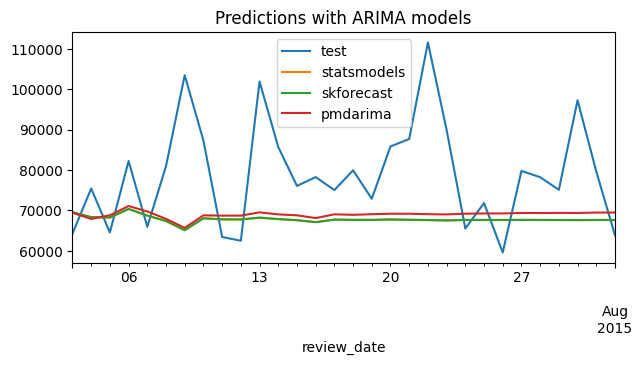

In [104]:
fig, ax = plt.subplots(figsize=(7, 3))
validation_df["gap"].plot(ax=ax, label="test")
predictions_statsmodels.plot(ax=ax, label="statsmodels")
predictions_skforecast.plot(ax=ax, label="skforecast")
predictions_pdmarima.plot(ax=ax, label="pmdarima")
ax.set_title("Predictions with ARIMA models")
ax.legend()

In [107]:
rmse_statsmodels = root_mean_squared_error(
    predictions_statsmodels, validation_df["gap"]
)
rmse_skforecast = root_mean_squared_error(predictions_skforecast, validation_df["gap"])
rmse_pmdarima = root_mean_squared_error(predictions_pdmarima, validation_df["gap"])

In [108]:
print(f"rmse statsmodels: {rmse_statsmodels}")
print(f"rmse skforecast: {rmse_skforecast}")
print(f"rmse pmdarima: {rmse_pmdarima}")

rmse statsmodels: 17137.915142801918
rmse skforecast: 17137.915142801918
rmse pmdarima: 16358.465265538322


## Arima Rolling training